## 보스턴 주택 가격 데이터셋

1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간 값을 예측해 보겠습니다.

여기서 사용할 데이터셋은 이전 두 개의 예제와 다릅니다. 데이터 포인트가 506개로 비교적 개수가 적고 404개는 훈련 샘플로 102개는 테스트 샘플로 나누어져 있습니다. 입력 데이터에 있는 각 특성(예를 들어 범죄율)은 스케일이 서로 다릅니다. 어떤 값은 0과 1 사이의 비율을 나타내고 어떤 것은 1과 12 사이의 값을 가지거나 1과 100 사이의 값을 가집니다.

In [1]:
from keras.datasets import boston_housing

# 여기선 분류가 아닌 회귀 예측이기 때문에 레이블이 아닌 타겟으로 명명
(train_data, train_target), (test_data, test_target) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [2]:
print(train_data.shape, test_data.shape)

(404, 13) (102, 13)


In [3]:
train_target[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [4]:
# 데이터 정규화
# Standard Scaler의 원리와 동일한 방식으로 정규화해 보자.

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data = (train_data-mean)/std

In [5]:
# 테스트 데이터도 정규화하는데, 이 때 트레인 데이터 관련 값으로 정규화한다
# 머신러닝 작업 과정에서는 절대로 테스트 데이터와 관련한 그 어떠한 연산 값도 사용하면 안 됨.
# 데이터 정규화 같은 간단한 작업도 반드시 트레인 데이터 연산 값을 사용하기!

test_data = (test_data-mean)/std

In [6]:
print(train_data[:1], test_data[:1])

[[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
   0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
   0.8252202 ]] [[ 1.55369355 -0.48361547  1.0283258  -0.25683275  1.03838067  0.23545815
   1.11048828 -0.93976936  1.67588577  1.5652875   0.78447637 -3.48459553
   2.25092074]]


In [7]:
print(train_data.mean()) # 평균은 0, 표준편차는 1인 정규분포 꼴로 만들었다
print(train_data.std())

2.6016254395785847e-15
0.9999999999999993


In [8]:
# 모델 구성

from tensorflow.keras import models, layers
def modeling():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],))) # 열 갯수의 값을 가진 한 줄의 벡터
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1)) # 예측한 값 그 자체를 받아야 하므로 활성화 함수 필요 없음

  model.compile(optimizer = 'rmsprop',
                loss = 'mse',                    # 이건 MSE
                metrics=['mean_absolute_error']) # 이건 MAE
  return model

In [9]:
# K-fold 교차검증 가보자고 
import numpy as np

k = 4
size = len(train_data) // k   # 404 // 4 = 101
epoch = 100

score = []

for i in range(k):
  print(f'<<< {i+1}번째 검증 세트 >>>\n')
  # 검증 데이터 분리
  val_data = train_data[i*size : (i+1)*size]
  val_target = train_target[i*size : (i+1)*size]

  # 훈련 데이터는 검증을 제외한 나머지 전체
  partial_data = np.concatenate([train_data[:i*size],
                                 train_data[(i+1)*size:]], axis=0)
  partial_target = np.concatenate([train_target[:i*size],
                                 train_target[(i+1)*size:]], axis=0)
  
  # 모델 불러오기
  model = modeling()
  model.fit(partial_data, partial_target,
            epochs=epoch, batch_size=1, verbose=False)
  val_mse, val_mae = model.evaluate(val_data, val_target, verbose=0)
  score.append(val_mae)

<<< 1번째 검증 세트 >>>

<<< 2번째 검증 세트 >>>

<<< 3번째 검증 세트 >>>

<<< 4번째 검증 세트 >>>



In [10]:
np.round(score,3)

array([1.978, 2.823, 2.639, 2.501])

In [11]:
np.mean(score).round(3)

2.485

In [12]:
from tensorflow.keras import backend as K
# 메모리 해제 방법
K.clear_session()

#### [과제] epoch를 500으로 적용, 검증 MAE 기록을 남겨 시각화

In [13]:
k = 4
size = len(train_data) // k
epoch = 500

MAE = []

for i in range(k):
  print(f'<<< {i+1}번째 검증 세트 >>>\n')
  # 검증 데이터 분리
  val_data = train_data[i*size : (i+1)*size]
  val_target = train_target[i*size : (i+1)*size]

  # 훈련 데이터는 검증을 제외한 나머지 전체
  partial_data = np.concatenate([train_data[:i*size],
                                 train_data[(i+1)*size:]], axis=0)
  partial_target = np.concatenate([train_target[:i*size],
                                 train_target[(i+1)*size:]], axis=0)
  
  # 모델 불러오기
  model = modeling()
  history = model.fit(partial_data, partial_target, validation_data=(val_data,val_target),
                      epochs=epoch, batch_size=1, verbose=False)
  MAE.append(history.history['val_mean_absolute_error'])

  print('>>> 완료!')

<<< 1번째 검증 세트 >>>

>>> 완료!
<<< 2번째 검증 세트 >>>

>>> 완료!
<<< 3번째 검증 세트 >>>

>>> 완료!
<<< 4번째 검증 세트 >>>

>>> 완료!


In [14]:
ave_mae = [np.mean([j[i] for j in MAE]) for i in range(epoch)]

In [15]:
# 위에서 for문을 돌리는 이유는 간단함.
# MAE의 한 성분은
print(np.array(MAE).shape)
# 이렇게 한 행이 500개 성분으로 구성된 4번의 검증 결과가 들어 있기 때문이다.

# for문을 돌리고 난 후의 결과는 아래와 같다.
print(np.array(ave_mae).shape)
# 폴드 별로 같은 에포크 회차의 mae 평균을 내는 것으로, 다시 말해 4 폴드의 에포크 회차별 평균이 들어 있다.

(4, 500)
(500,)


In [16]:
print(np.round(ave_mae[:5],3))

[4.338 3.498 3.094 3.021 2.865]


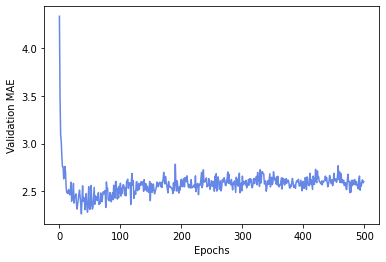

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(epoch), ave_mae, color='royalblue', alpha=0.8)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [19]:
# 최초 몇 건이 편차가 좀 심하고 변동폭도 크니까 좀 가다듬어 보자.
trim = []
for i in ave_mae[10:]:
  if trim:
    trim.append(trim[-1]*0.9 + i*0.1) # 이전에 계산된 이동평균에 factor(0.9)를 곱하고, 현재 지점에 (1-factor)를 곱한 것이 지수이동평균
  else: trim.append(i)

In [23]:
print(np.round(ave_mae[10:20],3))
print(np.round(trim[:10],3))

[2.706 2.543 2.486 2.497 2.476 2.517 2.5   2.462 2.517 2.595]
[2.706 2.69  2.669 2.652 2.634 2.623 2.61  2.596 2.588 2.588]


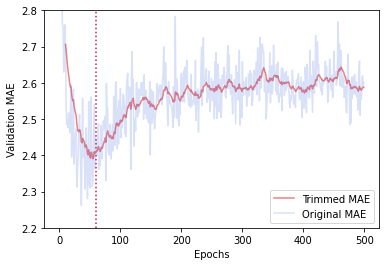

In [34]:
plt.plot(np.arange(10,epoch), trim, color='lightcoral', label='Trimmed MAE')
plt.plot(range(epoch), ave_mae, color='royalblue', alpha=0.2, label='Original MAE')
plt.ylim(2.2,2.8)
plt.vlines(60,2.2,2.8, color='crimson', linestyle=':') # 이 이후로는 에포크가 증가함에 따라 오차값도 커짐. 즉, 과대적합이 시작됨.
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()